# Project - Sales Forecasting Accuracy Increasing 

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from scipy.optimize import minimize
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('For USML.csv', sep=";")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 13 columns):
Period        81 non-null int64
Forecast 1    81 non-null int64
Actual 1      81 non-null int64
Forecast 2    81 non-null int64
Actual 2      81 non-null int64
Forecast 3    81 non-null int64
Actual 3      81 non-null int64
Forecast 4    81 non-null int64
Actual 4      81 non-null int64
Forecast 5    81 non-null int64
Actual 5      81 non-null int64
Forecast 6    81 non-null int64
Actual 6      81 non-null int64
dtypes: int64(13)
memory usage: 8.3 KB


In [4]:
data.describe()

,Period,Forecast 1,Actual 1,Forecast 2,Actual 2,Forecast 3,Actual 3,Forecast 4,Actual 4,Forecast 5,Actual 5,Forecast 6,Actual 6
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,41.000000,9056.345679,8701.000000,878.074074,992.444444,3416.753086,3237.037037,891.358025,881.888889,48.876543,165.148148,57.925926,105.925926
std,23.526581,2793.121874,2573.329633,463.331193,705.503774,1032.982424,1084.246391,380.930220,645.320754,70.220792,360.988300,80.966162,160.372830
min,1.000000,2940.000000,3885.000000,269.000000,72.000000,1500.000000,858.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,6830.000000,6867.000000,525.000000,537.000000,2640.000000,2382.000000,600.000000,408.000000,0.000000,42.000000,0.000000,12.000000
50%,41.000000,9150.000000,8109.000000,840.000000,834.000000,3300.000000,3345.000000,870.000000,738.000000,0.000000,90.000000,0.000000,51.000000
75%,61.000000,10620.000000,10611.000000,1050.000000,1311.000000,4050.000000,3762.000000,1095.000000,1182.000000,90.000000,156.000000,120.000000,120.000000
max,81.000000,15150.000000,15396.000000,3099.000000,3966.000000,5850.000000,7365.000000,1827.000000,3270.000000,426.000000,3180.000000,291.000000,879.000000


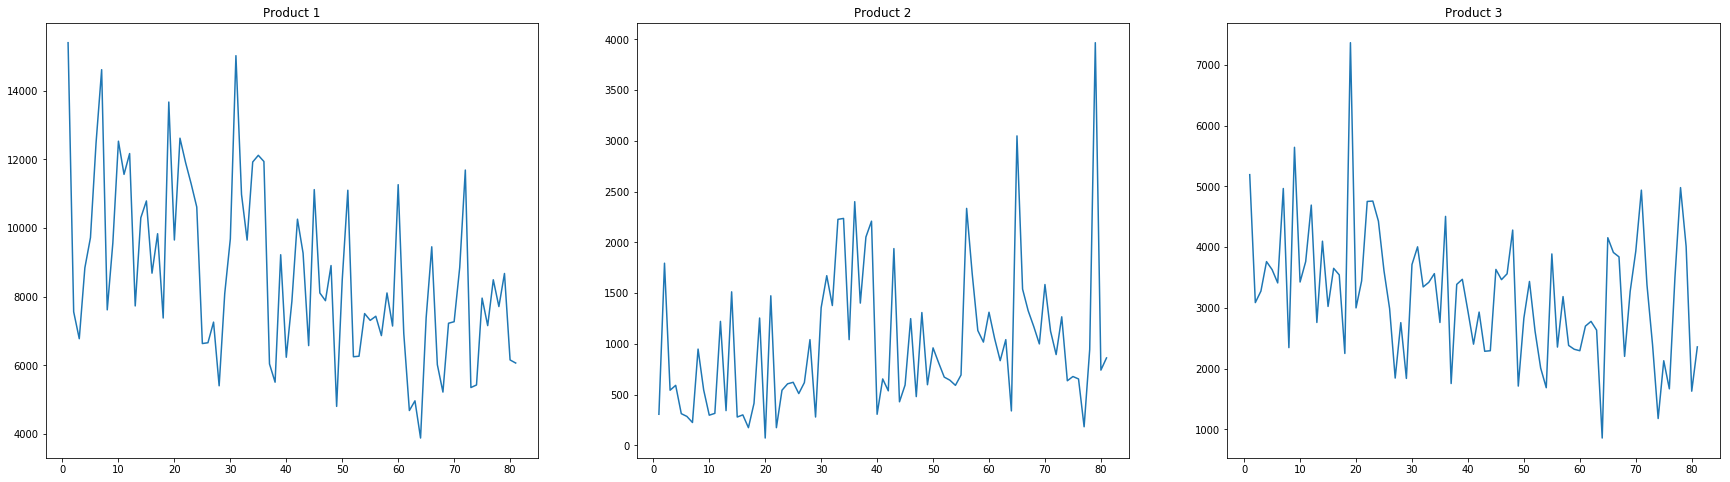

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 8));
axes[0].plot(data["Period"],data["Actual 1"]);
axes[0].set_title("Product 1");
axes[1].plot(data["Period"],data["Actual 2"]);
axes[1].set_title("Product 2");
axes[2].plot(data["Period"],data["Actual 3"]);
axes[2].set_title("Product 3");

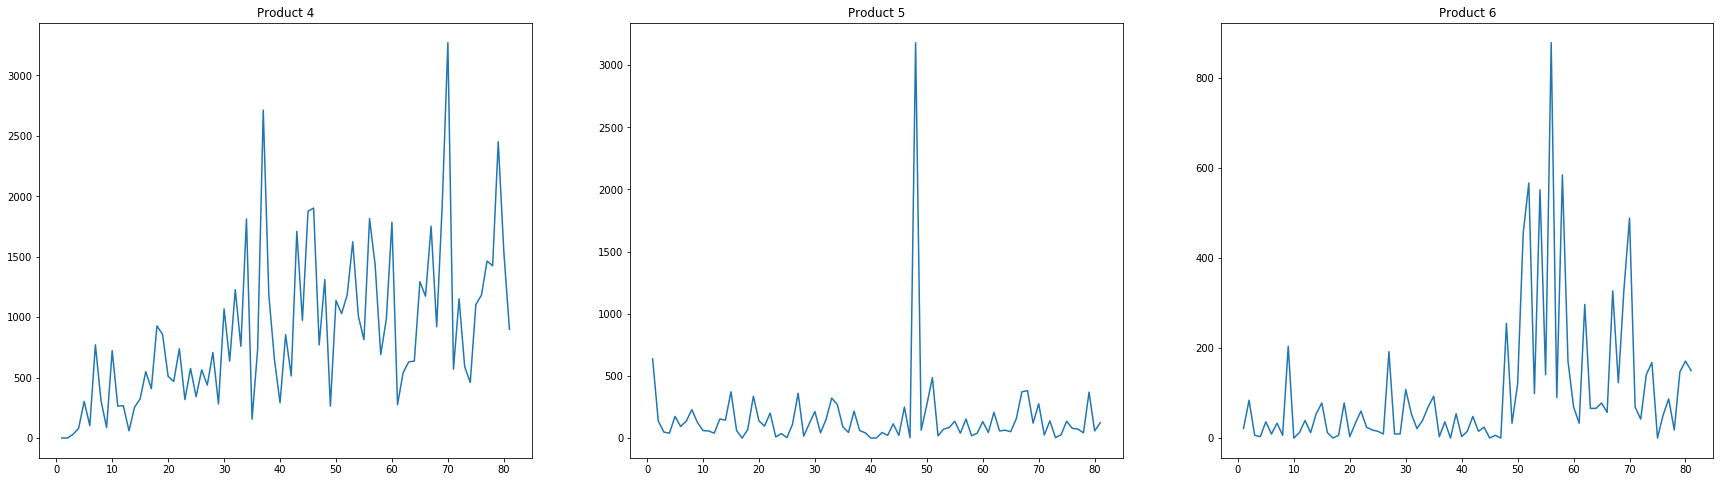

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 8));
axes[0].plot(data["Period"],data["Actual 4"]);
axes[0].set_title("Product 4");
axes[1].plot(data["Period"],data["Actual 5"]);
axes[1].set_title("Product 5");
axes[2].plot(data["Period"],data["Actual 6"]);
axes[2].set_title("Product 6");

# ARIMA Product #2

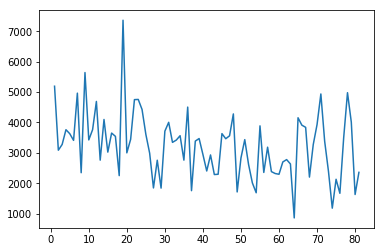

In [7]:
#We can see that Sales dataset has a clear trend. This suggests that the time series is not stationary and 
#will require differencing to make it stationary, at least a difference order of 1.
plt.plot(data["Period"],data["Actual 3"]);

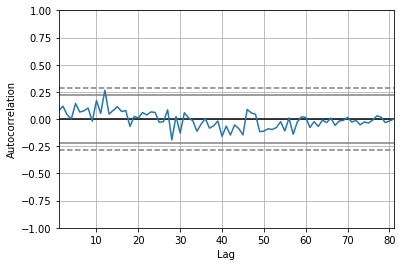

In [8]:
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
#Let’s also take a quick look at an autocorrelation plot of the time series. 
#We can see that there is no significant correlation with the lags 
#A good starting point for the AR parameter of the model may be 0.
autocorrelation_plot(data["Actual 3"]);

count      81.000000
mean     3237.037037
std      1084.246391
min       858.000000
25%      2382.000000
50%      3345.000000
75%      3762.000000
max      7365.000000
Name: Actual 3, dtype: float64

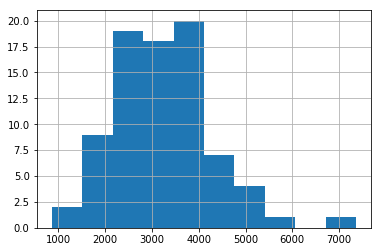

In [9]:
itog1 = data["Actual 3"].describe()
data["Actual 3"].hist()
itog1

Как можно заметить из характеристик и гистограммы, ряд у нас не однородный и имеет относительно 
большой разброс о чем свидетельствует коэффициент вариации: LaTeX:V = \frac {\sigma}{\bar{x}}, где 
        LaTeX:\sigma — cреднеквадратическое отклонение, LaTeX:\bar{x} — среднее арифметическое выборки. В нашем случае он равен:

In [10]:
print("V = %f" % (itog1['std']/itog1['mean']))

V = 0.334950


Проведем тест Харки — Бера для определения номарльности распределения, чтобы подтвердить предположение об однородности. Для этого в существует функция jarque_bera(), которая возвращает значения данной статистики:

In [11]:
from statsmodels.iolib.table import SimpleTable
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(data["Actual 3"])
a = np.vstack([jb_test])
itog1 = SimpleTable(a, row)
print (itog1)

        JB                p-value               skew            kurtosis    
----------------------------------------------------------------------------
13.126211096774282 0.0014114954294060865 0.656647386890915 4.471225533198393
----------------------------------------------------------------------------


#https://habr.com/post/207160/
#Значение данной статистика свидетельствует о том, нулевая гипотеза о нормальности распределения
#отвергается с большой вероятностью (probably > 0.05), и, следовательно, наш ряд НЕ имеет нормального распределения.

Многие методы и модели основаны на предположениях о стационарности ряда, но как было замечено ранее наш ряд таковым скорее всего не является. Поэтому для проверки проверки стационарности давайте проведем обобщенный тест Дикки-Фуллера на наличие единичных корней. Для этого в модуле statsmodels есть функция adfuller():

In [12]:
test = sm.tsa.adfuller(data["Actual 3"])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -8.288827980249545
p-value:  4.316827806035831e-13
Critical values:  {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625}
единичных корней нет, ряд стационарен


Проведенный тест подтвердил предположения о не стационарности ряда. Во многих случаях взятие разности рядов позволяет это сделать.Если, например, первые разности ряда стационарны, то он называется интегрированным рядом первого порядка.
Итак, давайте определим порядок интегрированного ряда для нашего ряда:

In [13]:
ts1 = data["Actual 3"].diff(periods=1).dropna()

В коде выше функция diff() вычисляет разность исходного ряда с рядом с заданным смещением периода. Период смещения передается как параметр period. Т.к. в разности первое значение получиться неопределенным, то нам надо избавиться от него для этого и используется метод dropna().
Проверим получившийся ряд на стационарность:


In [14]:
test = sm.tsa.adfuller(ts1)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -5.368833761896208
p-value:  3.93696979095173e-06
Critical values:  {'1%': -3.528889992207215, '5%': -2.9044395987933362, '10%': -2.589655654274312}
единичных корней нет, ряд стационарен


Как видно из кода выше получившийся ряд первых разностей приблизился к стационарному. Для полной уверенности разобъем его на несколько промежутков и убедимся мат. ожидания на разных интервалах:

In [15]:
m = ts1.index[int(len(ts1.index)/2+1)]
r1 = sm.stats.DescrStatsW(ts1[m:])
r2 = sm.stats.DescrStatsW(ts1[:m])
print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.829413975035827


Высокое p-value дает нам возможность утверждать, что нулевая гипотеза о равенстве средних верна, что свидетельствует о стационарности ряда. Осталось убедиться в отсутствии тренда для этого построим график нашего нового ряда:

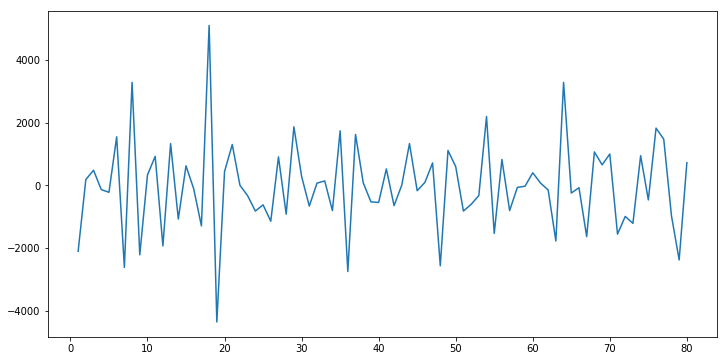

In [16]:
ts1.plot(figsize=(12,6));

Тренд действительно отсутствует, таким образом ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка.
Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:
p — порядок компоненты AR
d — порядок интегрированного ряда
q — порядок компонетны MA

Параметр d есть и он равет 1, осталось определить p и q. Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.
ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.
Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: plot_acf() и plot_pacf(). Они выводят графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций. Нужно отметить, что количество лагов в функциях и определяет число значимых коэффициентов. Итак, наши функции выглядят так:

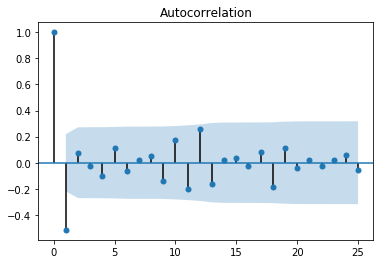

In [17]:
#ig = plt.figure(figsize=(12,8))
#ax1 = fig.add_subplot(211)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts1,lags=25);

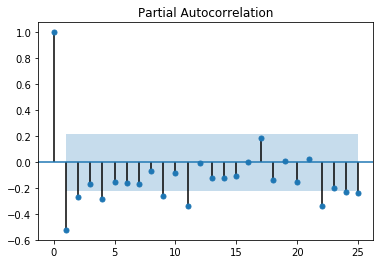

In [18]:
#ax2 = fig.add_subplot(212)
plot_pacf(ts1, lags=25);

После изучения коррелограммы PACF можно сделать вывод, что p = 1, т.к. на ней только 1 лаг сильно отличнен от нуля. По коррелограмме ACF можно увидеть, что q = 1, т.к. после лага 1 значении функций резко падают.
Итак, когда известны все параметры можно построить модель, но для ее построения мы возмем не все данные, а только часть. Данные из части не попавших в модель мы оставим для проверки точности прогноза нашей модели:

In [19]:
ts1_model = data["Actual 3"][:70]
model1 = sm.tsa.ARIMA(ts1_model, order=(0,1,1)).fit(disp=0)

In [20]:
print (model1.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Actual 3   No. Observations:                   69
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -574.452
Method:                       css-mle   S.D. of innovations            968.432
Date:                Tue, 19 Mar 2019   AIC                           1154.904
Time:                        17:28:47   BIC                           1161.606
Sample:                             1   HQIC                          1157.563
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -19.2137      5.729     -3.354      0.001     -30.442      -7.986
ma.L1.D.Actual 3    -1.0000      0.044    -22.741      0.000      -1.086      -0.914
                            

Как видно из данной информации в нашей модели все коэффициенты значимые и можно перейти к оценке модели.

Проверим остатки данной модели на соответствие «белому шуму», а также проанализируем коррелограму остатков, так как это может нам помочь в определении важных для включения и прогнозирования элементов регрессии.
Итак первое, что мы сделаем это проведем Q-тест Льюнга — Бокса для проверки гипотезы о том, что остатки случайны, т. е. являются «белым шумом». Данный тест проводится на остатках модели ARIMA. Таким образом, нам надо сначала получить остатки модели и построить для них ACF, а затем к получившимся коэффициентам приметить тест. С помощью statsmadels это можно сделать так:

In [21]:
q_test = sm.tsa.stattools.acf(model1.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print (pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    1.562375  0.211318
1    1.987417  0.370201
2    2.237455  0.524609
3    2.781913  0.594959
4    2.919332  0.712421
5    5.994815  0.423771
6    6.444622  0.488894
7    6.677260  0.571820
8    7.340217  0.601744
9    8.640263  0.566550
10   9.028107  0.619298
11  11.685416  0.471263
12  12.141748  0.516056
13  12.438555  0.571128
14  13.610768  0.555230
15  14.154420  0.587211
16  14.250307  0.649311
17  18.667455  0.412564
18  18.830205  0.467776
19  20.167002  0.447527
20  20.459885  0.492322
21  20.527423  0.550084
22  20.547336  0.608710
23  21.404238  0.614779
24  21.621201  0.657512
25  21.749065  0.702345
26  24.631576  0.595101
27  27.848463  0.472499
28  29.081683  0.460818
29  33.113962  0.317618
30  33.273064  0.357107
31  33.279996  0.404740
32  33.297426  0.452789
33  33.568767  0.488622
34  33.570849  0.537103
35  35.505145  0.491953
36  36.725380  0.481798
37  36.727487  0.528241
38  36.837592  0.568907
39  39.700645  0.483601


Значение данной статистики и p-values, свидетельствуют о том, что гипотеза о случайности остатков не отвергается, и скорее всего данный процесс представляет «белый шум».
Теперь давайте расчитаем коэффициент детерминацииLaTeX:R^2, чтобы понять какой процент наблюдений описывает данная модель:

In [22]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
pred1 = model1.predict(69,80,typ="levels")
trn1 = data["Actual 3"][69:]
r2 = r2_score(trn1, pred1)
print ('R^2: %1.2f' % r2)

R^2: -0.15


In [23]:
pred1.shape

(12,)

In [24]:
trn1.shape

(12,)

In [25]:
mean_squared_error(trn1,pred1)

1766324.9284711992

In [26]:
mean_absolute_error(trn1,pred1)

1096.539249648863

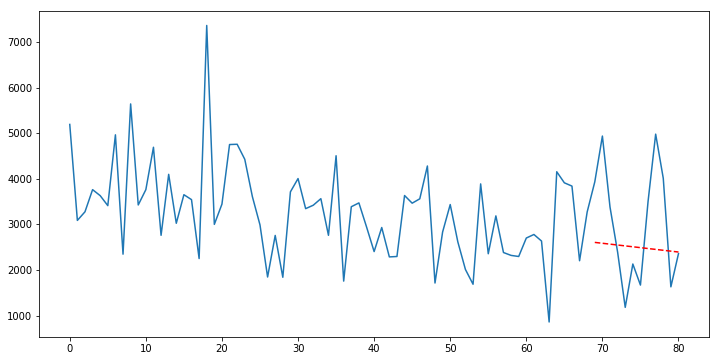

In [27]:
data["Actual 3"].plot(figsize=(12,6))
pred1.plot(style='r--');

# MAPE, GMRAE, UMBRAE

In [28]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
round(mean_absolute_percentage_error(trn1, pred1), 2)

38.55

In [30]:
def gmrae(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true1 = np.array(data["Actual 3"][68:80])
    return (np.prod(np.abs((y_true - y_pred)/(y_true - y_true1))))**(1/len(y_true))

In [31]:
round(gmrae(trn1, pred1), 2)

0.67

In [32]:
len(trn1)

12

In [33]:
np.array(trn1)

array([3933, 4938, 3381, 2391, 1179, 2130, 1668, 3501, 4980, 4011, 1629,
       2358])

In [34]:
data["Actual 3"][68:80]

68    3273
69    3933
70    4938
71    3381
72    2391
73    1179
74    2130
75    1668
76    3501
77    4980
78    4011
79    1629
Name: Actual 3, dtype: int64

In [35]:
pred1

69    2604.345466
70    2585.167512
71    2565.953780
72    2546.740048
73    2527.526317
74    2508.312585
75    2489.098853
76    2469.885121
77    2450.671389
78    2431.457657
79    2412.243926
80    2393.030194
dtype: float64

In [84]:
def umbrae(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true1 = np.array(data["Actual 3"][68:80])
    mbrae=(np.sum(np.abs(y_true - y_pred)/(np.abs(y_true - y_pred)+np.abs(y_true - y_true1))))/len(y_true)
    return mbrae/(1-mbrae)

In [85]:
round(umbrae(trn1, pred1), 2)

0.77

### DOUBLE Exponentional smoothing Product #1

In [38]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

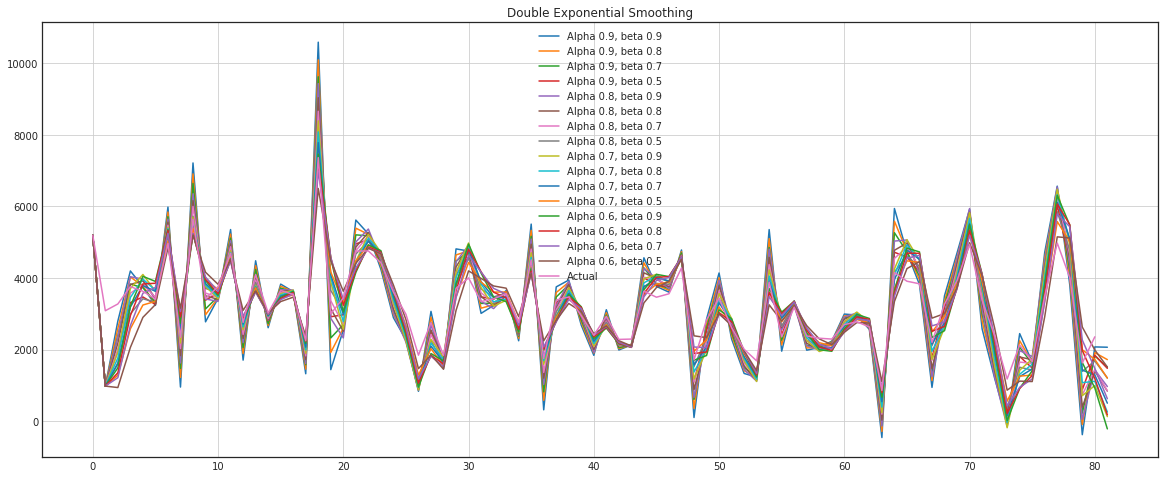

In [39]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.8,0.7,0.6]:
        for beta in [0.9, 0.8,0.7,0.5]:
            plt.plot(double_exponential_smoothing(data["Actual 3"], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(data["Actual 3"].values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

Now we have to tune two parameters — α and β. The former is responsible for the series smoothing around trend, and the latter for the smoothing of the trend itself. The bigger the values, the more weight the latest observations will have and the less smoothed the model series will be. Combinations of the parameters may produce really weird results, especially if set manually. We’ll look into choosing parameters automatically in a bit, immediately after triple exponential smoothing.

In [40]:
double_exponential_smoothing(data["Actual 3"],0.9,0.1)[69:81]

[3955.157351649025,
 5022.899713991918,
 3580.6029759669354,
 2438.3090343274134,
 1119.9418270739939,
 1934.9103419119924,
 1576.5852626237129,
 3363.650081058751,
 5018.928055606967,
 4221.642328057163,
 1764.7759457770367,
 2228.5794724290913]

In [41]:
data["Actual 3"][69:81]

69    3933
70    4938
71    3381
72    2391
73    1179
74    2130
75    1668
76    3501
77    4980
78    4011
79    1629
80    2358
Name: Actual 3, dtype: int64

In [42]:
for alpha in [0.9, 0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
        for beta in [0.9, 0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
            mape=mean_absolute_percentage_error(data["Actual 3"][69:81], double_exponential_smoothing(data["Actual 3"],alpha,beta)[69:81])
            print(alpha,"  ",beta,"  ", round(mape,3))

0.9    0.9    36.608
0.9    0.8    32.704
0.9    0.7    29.42
0.9    0.6    26.2
0.9    0.5    22.155
0.9    0.4    17.644
0.9    0.3    12.792
0.9    0.2    7.715
0.9    0.1    4.466
0.8    0.9    35.279
0.8    0.8    31.679
0.8    0.7    27.971
0.8    0.6    24.199
0.8    0.5    19.669
0.8    0.4    14.837
0.8    0.3    12.243
0.8    0.2    9.309
0.8    0.1    8.509
0.7    0.9    34.111
0.7    0.8    29.744
0.7    0.7    25.263
0.7    0.6    21.47
0.7    0.5    19.515
0.7    0.4    17.155
0.7    0.3    14.479
0.7    0.2    13.453
0.7    0.1    13.709
0.6    0.9    29.749
0.6    0.8    28.081
0.6    0.7    26.269
0.6    0.6    24.611
0.6    0.5    22.322
0.6    0.4    19.714
0.6    0.3    19.27
0.6    0.2    19.147
0.6    0.1    18.67
0.5    0.9    33.376
0.5    0.8    31.648
0.5    0.7    29.438
0.5    0.6    26.911
0.5    0.5    26.147
0.5    0.4    26.592
0.5    0.3    26.024
0.5    0.2    24.775
0.5    0.1    23.812
0.4    0.9    34.962
0.4    0.8    34.839
0.4    0.7    35.698
0.

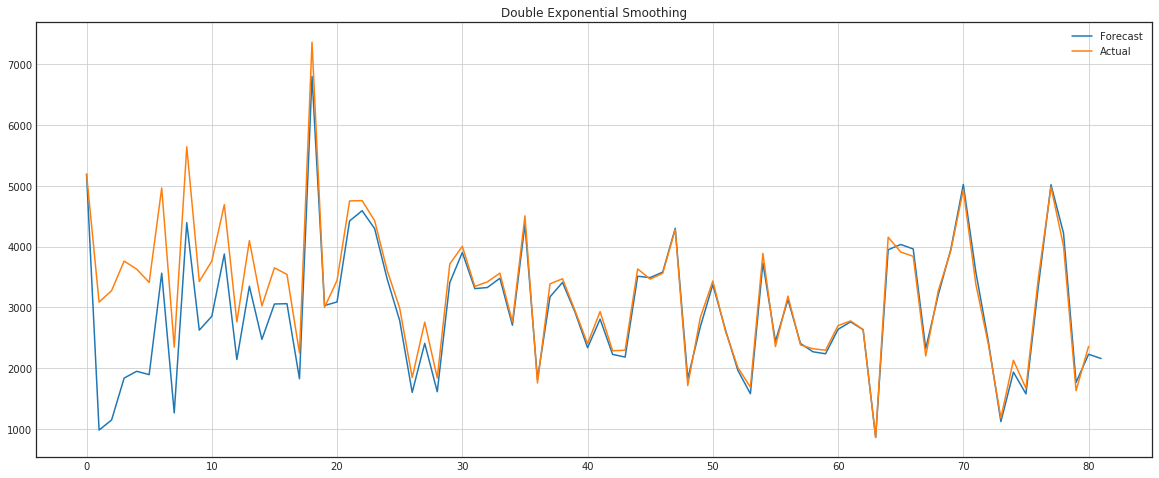

In [43]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(double_exponential_smoothing(data["Actual 3"], 0.9, 0.1), label = "Forecast");
    plt.plot(data["Actual 3"].values, label = "Actual");
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [44]:
round(mean_absolute_percentage_error(data["Actual 3"][69:81], 
                                     double_exponential_smoothing(data["Actual 3"],0.9,0.1)[69:81]),2)

4.47

In [45]:
round(gmrae(data["Actual 3"][69:81], 
                                     double_exponential_smoothing(data["Actual 3"],0.9,0.1)[69:81]),2)

0.09

In [46]:
round(umbrae(data["Actual 3"][69:81], 
                                     double_exponential_smoothing(data["Actual 3"],0.9,0.1)[69:81]),2)

0.09

## LINEAR REGRESSION

In [47]:
# Creating a copy of the initial datagrame to make various transformations 
xg = pd.DataFrame(data["Actual 3"].copy())
xg.columns = ["y"]

# Adding the lag of the target variable from 6 steps back up to 24
for i in range(1, 13):
    xg["lag_{}".format(i)] = xg.y.shift(i)

In [48]:
xg.head(13)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,5193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3087,5193.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3276,3087.0,5193.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3762,3276.0,3087.0,5193.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3630,3762.0,3276.0,3087.0,5193.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3411,3630.0,3762.0,3276.0,3087.0,5193.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4965,3411.0,3630.0,3762.0,3276.0,3087.0,5193.0,NaN,NaN,NaN,NaN,NaN,NaN
7,2346,4965.0,3411.0,3630.0,3762.0,3276.0,3087.0,5193.0,NaN,NaN,NaN,NaN,NaN
8,5643,2346.0,4965.0,3411.0,3630.0,3762.0,3276.0,3087.0,5193.0,NaN,NaN,NaN,NaN
9,3426,5643.0,2346.0,4965.0,3411.0,3630.0,3762.0,3276.0,3087.0,5193.0,NaN,NaN,NaN


In [49]:
xg=xg.dropna()

In [50]:
y = xg["y"]
X = xg.drop(["y"], axis=1)

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [52]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_squared_error")
        #mae = cv.mean() * (-1)
        deviation = np.sqrt(cv.std())
        
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    

In [53]:
# reserve 15% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.17)

In [54]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

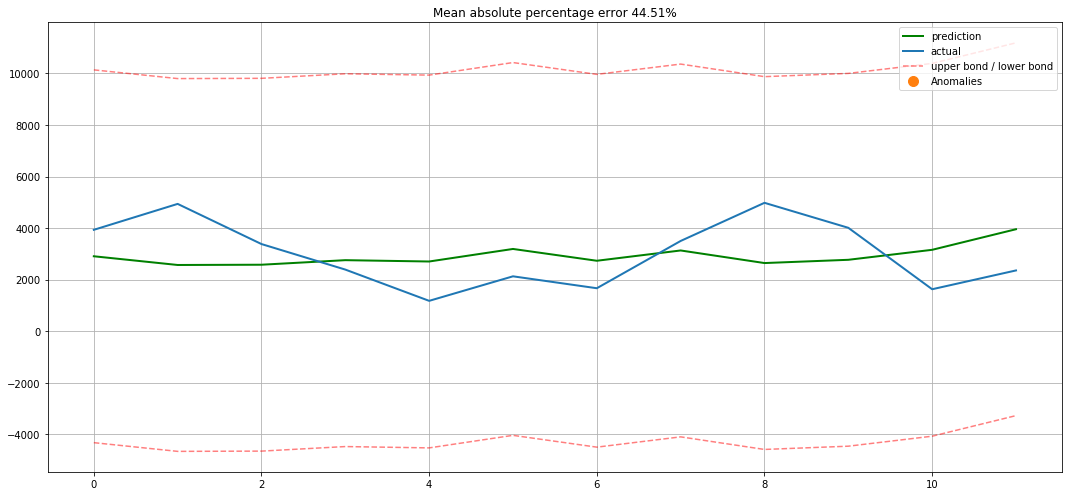

In [55]:
plotModelResults(lr, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

In [56]:
prediction = lr.predict(X_test)
print (prediction)

[2907.40088157 2569.59252174 2579.53845438 2756.23694219 2704.53652137
 3191.11057775 2733.33684509 3132.18230168 2644.28410957 2770.53440704
 3157.70154791 3956.15094408]


In [57]:
print (y_test)

69    3933
70    4938
71    3381
72    2391
73    1179
74    2130
75    1668
76    3501
77    4980
78    4011
79    1629
80    2358
Name: y, dtype: int64


In [58]:
round(mean_absolute_percentage_error(y_test, prediction),2)

50.51

In [59]:
round(gmrae(y_test, prediction), 2)

1.02

In [60]:
round(umbrae(y_test, prediction), 2)

0.51

## XGBOOST 

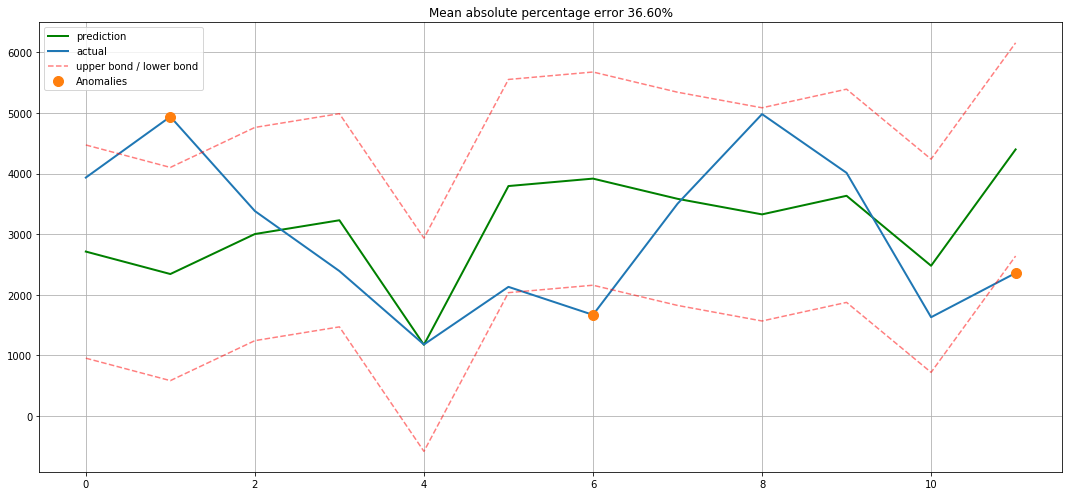

In [61]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

plotModelResults(xgb, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

In [62]:
prediction1 = xgb.predict(X_test)
print (prediction1)

[2712.3035 2341.7625 3001.509  3228.6907 1174.6252 3793.187  3915.884
 3582.6401 3325.774  3632.495  2478.1008 4397.362 ]


In [63]:
round(mean_absolute_percentage_error(y_test, prediction1),2)

43.89

In [64]:
round(gmrae(y_test, prediction1), 2)

0.54

In [65]:
round(umbrae(y_test, prediction1), 2)

0.45

# Facebook Prophet

In [66]:
from fbprophet import Prophet

In [67]:
ph1=pd.read_csv("For USML_date2.csv", sep=";")
ph1.tail(12)

,Date,Actual 1,Actual 2,Actual 3,Actual 4,Actual 5,Actual 6
69,31.07.2017,7272,1584,3933,3270,276,489
70,31.08.2017,8853,1125,4938,570,24,69
71,30.09.2017,11688,894,3381,1152,138,42
72,31.10.2017,5355,1266,2391,591,3,141
73,30.11.2017,5430,636,1179,459,27,168
74,31.12.2017,7959,678,2130,1104,135,0
75,31.01.2018,7158,654,1668,1182,78,51
76,28.02.2018,8493,183,3501,1464,72,87
77,31.03.2018,7713,945,4980,1425,42,18
78,30.04.2018,8676,3966,4011,2451,369,147


In [68]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [69]:
import pandas as pd
ph1 = pd.DataFrame({'ds':ph1['Date'], 'y':ph1["Actual 3"]})

In [70]:
prediction_size = 12
train_df = ph1[:-prediction_size]
train_df.tail(n=3)

,ds,y
66,30.04.2017,3840
67,31.05.2017,2202
68,30.06.2017,3273


In [71]:
m = Prophet()
m.fit(train_df)
predictions=12
future = m.make_future_dataframe(periods=predictions, freq='M')
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [72]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
76,2018-02-28,2403.176769,1946.925600,3659.360725,2403.155323,2403.196968,418.208094,418.208094,418.208094,418.208094,418.208094,418.208094,0.0,0.0,0.0,2821.384863
77,2018-03-31,2379.294252,1379.738030,3098.185749,2379.268583,2379.318745,-108.864342,-108.864342,-108.864342,-108.864342,-108.864342,-108.864342,0.0,0.0,0.0,2270.429910
78,2018-04-30,2356.182139,2520.205244,4245.970048,2356.152187,2356.210634,1001.704936,1001.704936,1001.704936,1001.704936,1001.704936,1001.704936,0.0,0.0,0.0,3357.887076
79,2018-05-31,2332.299623,327.028288,2027.321719,2332.264692,2332.331134,-1159.187174,-1159.187174,-1159.187174,-1159.187174,-1159.187174,-1159.187174,0.0,0.0,0.0,1173.112449
80,2018-06-30,2309.187510,1876.543146,3571.501277,2309.147396,2309.224465,406.737033,406.737033,406.737033,406.737033,406.737033,406.737033,0.0,0.0,0.0,2715.924543


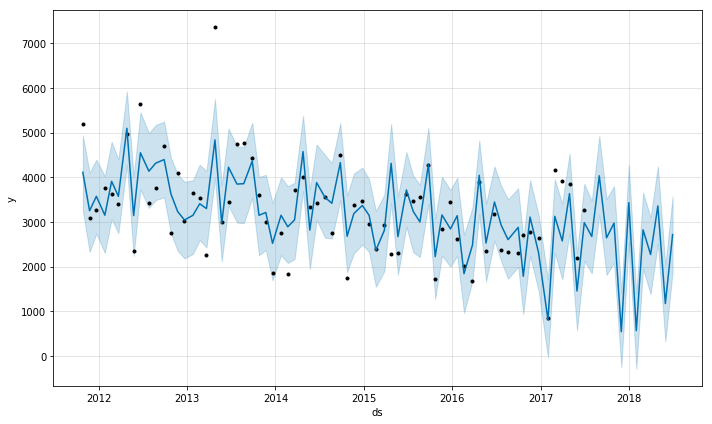

In [73]:
m.plot(forecast);

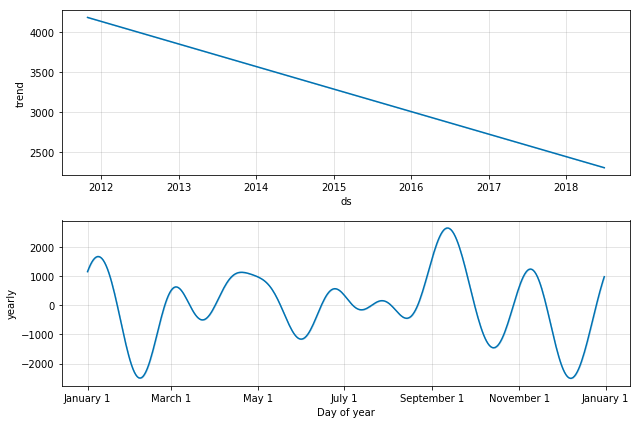

In [74]:
m.plot_components(forecast);

In [75]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index("ds"))

In [76]:
cmp_df = make_comparison_dataframe(ph1, forecast)
cmp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2018-02-28,2821.384863,1946.925600,3659.360725,3501
2018-03-31,2270.429910,1379.738030,3098.185749,4980
2018-04-30,3357.887076,2520.205244,4245.970048,4011
2018-05-31,1173.112449,327.028288,2027.321719,1629
2018-06-30,2715.924543,1876.543146,3571.501277,2358


In [77]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [78]:
for err_name, err_value in calculate_forecast_errors(cmp_df, predictions).items():
    print(err_name, err_value)

MAPE 34.25138841949427
MAE 948.3160264196355


In [79]:
cmp_df['y'][-12:]

ds
2017-07-31    3933
2017-08-31    4938
2017-09-30    3381
2017-10-31    2391
2017-11-30    1179
2017-12-31    2130
2018-01-31    1668
2018-02-28    3501
2018-03-31    4980
2018-04-30    4011
2018-05-31    1629
2018-06-30    2358
Name: y, dtype: int64

In [80]:
cmp_df['yhat'][-12:]

ds
2017-07-31    2673.787436
2017-08-31    4033.399454
2017-09-30    2644.447438
2017-10-31    2973.186205
2017-11-30     540.981745
2017-12-31    3430.314920
2018-01-31     565.202980
2018-02-28    2821.384863
2018-03-31    2270.429910
2018-04-30    3357.887076
2018-05-31    1173.112449
2018-06-30    2715.924543
Name: yhat, dtype: float64

In [81]:
round(mean_absolute_percentage_error(cmp_df['y'][-12:], cmp_df['yhat'][-12:]),2)

34.25

In [82]:
round(gmrae(cmp_df['y'][-12:], cmp_df['yhat'][-12:]), 2)

0.76

In [83]:
round(umbrae(cmp_df['y'][-12:], cmp_df['yhat'][-12:]), 2)

0.44